# Prophet template light con incertezza

In [726]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

### Scelgo una colonna e imposto il dataframe come vuole prophet

In [727]:
df = pd.read_excel('db_assunzioni.xlsx') #INSERIRE DATASET DA USARE
df.rename(columns={df.columns[0]:'ds'},inplace=True)
column = 'A02_L' #INSERIRE COLONNA SU CUI FARE L'ANALISI
df_ready = df[['ds',column]]
df_ready.rename(columns={column:'y'},inplace=True)
df_ready.head()

/home/davide/.local/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,ds,y
0,2010-01-01,29
1,2010-02-01,11
2,2010-03-01,56
3,2010-04-01,173
4,2010-05-01,39


In [728]:
first_1gen = 0
for d in df_ready['ds']:
    if d.day == 1 and d.month==1:
        break
    else:
        first_1gen += 1
first_1gen

0

Text(0.5, 1.0, 'A02_L')

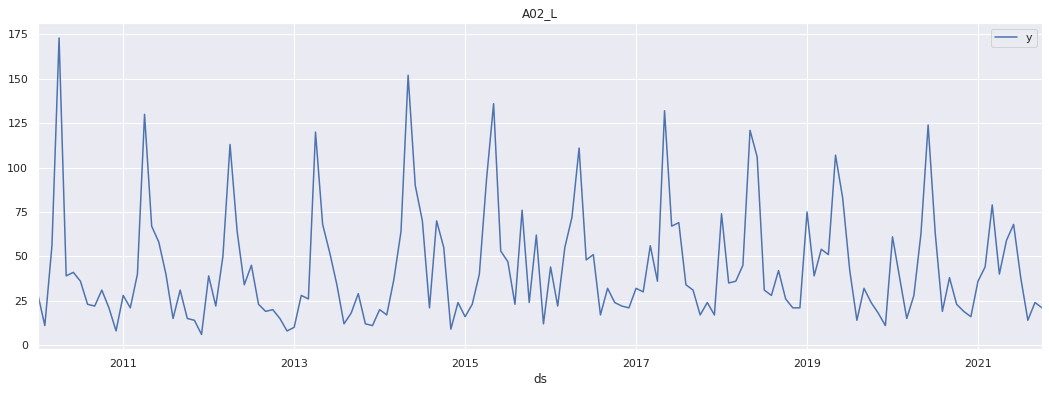

In [729]:
df_ready.set_index('ds').plot(figsize=(18,6))
plt.title(column)

## PARAMETRIZZAZIONE PROPHET

### PARAMETRI TREND PROPHET <br/>

1. **intervallo**: intervallo della serie in cui si cercano i change points e si è sensibili al trend <br/>
    Es. intervallo=0.8 -> i changepoints il trend verranno considerati dall'inizio fino al 80% della lunghezza della serie<br/>
    VALORE DEFAULT: 0.8<br/>
    PRO: aumento precisione nel seguire il trend a fine serie<br/>
    CONTRO: pericolo overfitting<br/>
    <br/>
2. **n_max_punti_cambio**: numero massimo di change points rilevabili<br/>
    VALORE DEFAULT: 25<br/>
    PRO: aumento dettaglio, aumento fitting sul trend<br/>
    CONTRO: troppi punti anche insignificanti, overfitting sul trend<br/><br/>
    <br/>
3. **sensibilita_cambio_trend**: sensibilita' ai cambi di trend<br/>
    VALORE DEFAULT: 0.05<br/>
    PRO: aumento precisione nel seguire il trend<br/>
    CONTRO: pericolo overfitting<br/><br/>


In [730]:
intervallo=0.9
n_max_punti_cambio=50
sensibilita_cambio_trend=1.5

### PARAMETRI STAGIONALITÀ PROPHET<br/>

1. **sensibilita_cambio_stagionalita**: sensibilità ai cambi di stagionalità<br/>
    VALORE DEFAULT: 10<br/>
    PRO: aumento precisione nel seguire stagionalità<br/>
    CONTRO: pericolo overfitting<br/>
    <br/>
2. **rilevazione_stagionalita_annuale**: rilevamento stagionalità annuale<br/>
    Usato per decidere se prophet deve rilevare la stagionalità annuale:<br/>
    'auto' decide automaticamente <br/>
    'True' rileva la stagionalità annuale <br/>
    'False' disabilita il rilevamento della stagionalità (da usare quando stagionalità molto bassa) <br/>
    VALORE DEFAULT: 'auto'<br/>
    
3. **modalita_stagionalita**: possibili modalità: 'additive' o 'multiplivative'<br/>
    additive: l'effetto della stagionalità si somma alla serie(usare con stagionalità stabile)<br/>
    multiplivative: l'effetto della stagionalità si moltiplica alla serie(usare con stagionalità variabile)<br/>
    VALORE DEFAULT:  'additive'<br/>

In [731]:
sensibilita_cambio_stagionalita = 10
rilevazione_stagionalita_annuale = 'auto'
modalita_stagionalita ='additive' 

### PARAMETRI INDECISIONE PROPHET (la documentazione ufficiale sconsiglia CALDAMENTE di non cambiare questi parametri)<br/>

1. **campioni_per_calcolo_incertezza**: numero campioni usati per il calcolo dell'incertezza<br/>
    Mettendo un valore diverso da zero prophet cambia faccia: cambia il modello statistico, viene introdotta l'incertezza anche sulle componenti singole: trend e stagionalità.<br/>
    Quando questo parametro vale zero viene calcolata solo l'incertezza in modo "statico" sull'andamento.<br/>
    Se impostato diverso da default impostare un valore di almeno 21 altrimenti l'algoritmo sull'incertezza non funziona a dovere e i risultati sono strani.<br/>
    VALORE DEFAULT: 0<br/><br/>
    **#WARNING ALTA TENSIONE# QUESTO PARAMETRO INTRODUCE DINAMICHE DIVERSE NEL MODELLO, INOLTRE:**<br/>
    **- PUò CAPITARE CHE IL NUMERO MASSIMO DI CHANGE POINTS DIVENTA PRATICAMENTE IL VALORE DI CHANGE POINTS EFFETTIVAMENTE PRESI: PERICOLO OVERFITTING**<br/>
    **- Abilitare questo parametro aumenta notevoltemte i tempi di computazione**<br/><br/>

2. **intervallo_incertezza**: incertezza visualizzata<br/>
    Se per esempio viene impostato a 0.8 viene visualizzata(nell'area azzurrina) la distribuzione dell'80% dei valori predetti più probabili <br/>
    Prophet internamente per ogni valore della serie non fa un'unica previsione ma una distribuzione<br/>
    Sempre nel caso di 0.8, sarebbe come dire a prophet: "Mi fai vedere dove stanno le tue previsioni tolte quelle meno probabili(20%) ?" <br/>
    VALORE DEFAULT: 0.8<br/><br/>

Con questi parametri impostati da me come sotto, spingo volutamente il modello ai sui limiti, "rilassandolo" al massimo ma con il solo scopo di avere informazioni mirate sul trend e sulla stagionalità


In [732]:
campioni_per_calcolo_incertezza=100
intervallo_incertezza=0.25

### Numero di mesi da predire

In [733]:
mesi = 12

---

## ANALISI 

In [734]:
%%capture
m2 = Prophet( 
                changepoint_range=intervallo,
                n_changepoints=n_max_punti_cambio,
                changepoint_prior_scale=sensibilita_cambio_trend,
                seasonality_prior_scale=sensibilita_cambio_stagionalita,
                seasonality_mode = modalita_stagionalita,
                yearly_seasonality=rilevazione_stagionalita_annuale,
                mcmc_samples=campioni_per_calcolo_incertezza,
                interval_width=intervallo_incertezza,
                uncertainty_samples=5000,
                )
m2.fit(df_ready);
future2 = m2.make_future_dataframe(periods=mesi,freq = 'MS')
forecast2 = m2.predict(future2);





Gradient evaluation took 0.000196 seconds
Gradient evaluation took 0.0002 seconds
Gradient evaluation took 0.000192 secondsGradient evaluation took 0.000195 seconds1000 transitions using 10 leapfrog steps per transition would take 1.96 seconds.


Adjust your expectations accordingly!1000 transitions using 10 leapfrog steps per transition would take 2 seconds.



1000 transitions using 10 leapfrog steps per transition would take 1.92 seconds.Adjust your expectations accordingly!1000 transitions using 10 leapfrog steps per transition would take 1.95 seconds.


Adjust your expectations accordingly!

Adjust your expectations accordingly!






         three stages of adaptation as currently configured.         Reducing each adaptation stage to 15%/75%/10% of


         the given number of warmup iterations:         the given number of warmup iterations:

         three stages of adaptation as currently configured.
         Reducing each adaptation stage to 15%/75%/10% of           ini

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)


Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Informational Message: The current Metropolis proposal is about to be rejected because of th

Iteration: 10 / 100 [ 10%]  (Warmup)
Iteration: 20 / 100 [ 20%]  (Warmup)
Iteration: 20 / 100 [ 20%]  (Warmup)
Iteration: 20 / 100 [ 20%]  (Warmup)
Iteration: 20 / 100 [ 20%]  (Warmup)
Iteration: 30 / 100 [ 30%]  (Warmup)
Iteration: 30 / 100 [ 30%]  (Warmup)
Iteration: 30 / 100 [ 30%]  (Warmup)
Iteration: 30 / 100 [ 30%]  (Warmup)
Iteration: 40 / 100 [ 40%]  (Warmup)
Iteration: 40 / 100 [ 40%]  (Warmup)
Iteration: 40 / 100 [ 40%]  (Warmup)
Iteration: 40 / 100 [ 40%]  (Warmup)
Iteration: 50 / 100 [ 50%]  (Warmup)
Iteration: 51 / 100 [ 51%]  (Sampling)
Iteration: 50 / 100 [ 50%]  (Warmup)
Iteration: 51 / 100 [ 51%]  (Sampling)
Iteration: 50 / 100 [ 50%]  (Warmup)
Iteration: 51 / 100 [ 51%]  (Sampling)
Iteration: 50 / 100 [ 50%]  (Warmup)
Iteration: 51 / 100 [ 51%]  (Sampling)
Iteration: 60 / 100 [ 60%]  (Sampling)
Iteration: 60 / 100 [ 60%]  (Sampling)
Iteration: 60 / 100 [ 60%]  (Sampling)
Iteration: 60 / 100 [ 60%]  (Sampling)
Iteration: 70 / 100 [ 70%]  (Sampling)
Iteration: 70 / 100 

### COMPONENTI

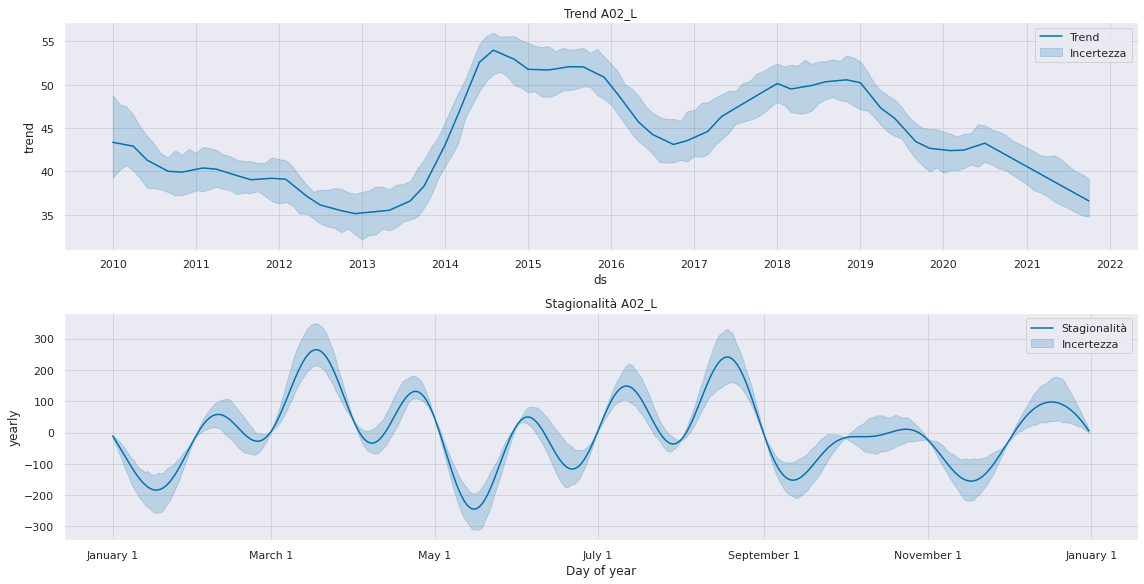

In [735]:
fig3 = m2.plot_components(forecast2[:-mesi],figsize=(16,8))
plt.title('Stagionalità '+ column)
plt.legend(['Stagionalità','Incertezza'])
plt.tight_layout()
fig3.axes[0].set_title('Trend ' + column)
fig3.axes[0].legend(['Trend','Incertezza'])
fig3.axes[0].set_xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]]);

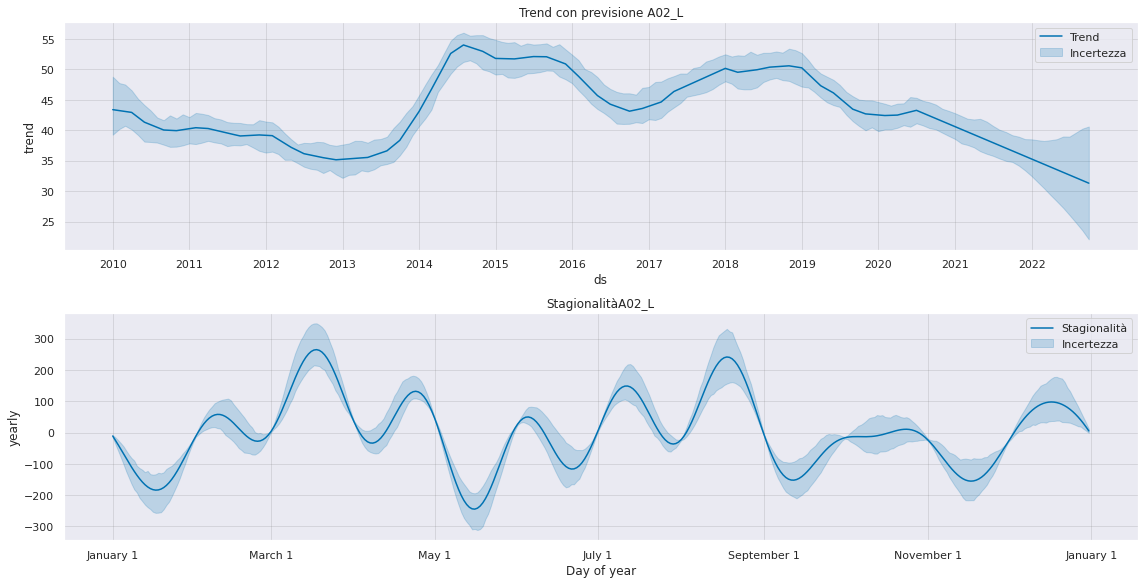

In [736]:
fig3 = m2.plot_components(forecast2[:],figsize=(16,8))
plt.title('Stagionalità'+ column)
plt.legend(['Stagionalità','Incertezza'])
plt.tight_layout()
fig3.axes[0].set_title('Trend con previsione ' + column)
fig3.axes[0].legend(['Trend','Incertezza'])
fig3.axes[0].set_xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]]);

### GRAFICO DEI PUNTI DI CAMBIO DI TREND

In [ ]:
df_ptc_p1 = pd.DataFrame()
df_ptc_p1['ds'] = forecast2['ds'][1:-mesi]
df_ptc_p1['ptc_change'] = forecast2['trend'].pct_change()
relevant_months_p1  = df_ptc_p1[df_ptc_p1['ptc_change'].apply(abs)*100>(0.8)]

df_ptc_p3 = pd.DataFrame()
df_ptc_p3['ds'] = forecast2['ds'][1:-mesi]
df_ptc_p3['ptc_change'] = forecast2['trend'].pct_change().pct_change().pct_change()
relevant_months_p3  = df_ptc_p3[df_ptc_p3['ptc_change'].apply(abs)>(80)]

In [ ]:
relevant_months_p1.to_excel('Mesi ad alta variazione di trend '+column+'.xlsx')
relevant_months_p3.to_excel('Change points rilevanti(Jerk)'+column+'.xlsx')

In [ ]:
def shitf_date_n_months(d,n):
    y = int(n/12) 
    m = d.month - n%12
    if m <=0:
        m = 12 + m
        y -= 1
    return pd.to_datetime(str(d.year + y)+'-'+str(m)+'-'+str(1))

In [ ]:
forecast2[['ds','trend']].set_index('ds').plot(figsize=(16,6))
for d in relevant_months_p1['ds']:
    plt.axvline(d,color='red',ls=':')
plt.xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]])
plt.xlabel('Data')
plt.ylabel('Trend '+column)
plt.legend(['Trend','Periodi forte variazione'])
plt.title('QUICK VIEW TREND '+column)
plt.tight_layout()
plt.show()

relevant_months_p3['ds'] = relevant_months_p3['ds'].apply(shitf_date_n_months,args=[1])
forecast2[['ds','trend']].set_index('ds').plot(figsize=(16,6))
for d in relevant_months_p3['ds']:
    plt.axvline(d,color='green',ls='-.')
plt.xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]])
plt.xlabel('Data')
plt.ylabel('Trend '+column)
plt.legend(['Trend','change points rilevanti'])
plt.title('QUICK VIEW TREND '+column)
plt.tight_layout()
plt.show()

In [737]:
#date changepoints
df = pd.DataFrame()
df['Change points '+column] = m2.changepoints
df.to_excel('Change points '+column+'.xlsx')

In [ ]:
fig = m2.plot(forecast2[:],figsize=(16,6))
plt.plot(forecast2[['ds','trend']].set_index('ds'),color='red')
for d in relevant_months_p3['ds']:
    plt.axvline(d,color='green',ls='--')
plt.xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]])
plt.xlabel('Data')
plt.ylabel(column)
plt.legend(['Reale','Previsione','Incertezza','Trend','Change points rilevanti'])
plt.title('QUICK VIEW '+column)
plt.tight_layout()
plt.show()

In [738]:
#numero di changepoints
print('Numero di change points: '+ str(len(m2.changepoints)))

Numero di change points: 50


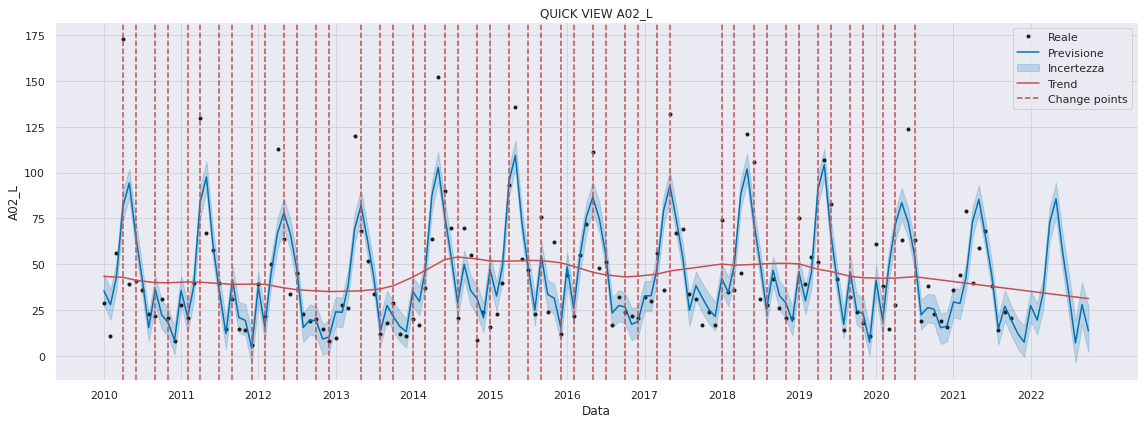

In [739]:
fig = m2.plot(forecast2[:],figsize=(16,6))
a = add_changepoints_to_plot(fig.gca(), m2, forecast2)
plt.xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]])
plt.xlabel('Data')
plt.ylabel(column)
plt.legend(['Reale','Previsione','Incertezza','Trend','Change points'])
plt.title('QUICK VIEW '+column)
plt.tight_layout()
plt.show()

---

### Analisi incertezza (se viene abilitata l'incertezza sulle componenti)

In [740]:
df_output = pd.DataFrame()
df_output['Incertezza assoluta trend'] = forecast2['trend_upper']-forecast2['trend_lower']
df_output['Variazione percentuale incertezza assoluta trend'] = (forecast2['trend_upper']-forecast2['trend_lower']).pct_change()*100
df_output['Incertezza assoluta stagionalità'] = forecast2['yearly_upper']-forecast2['yearly_lower']
df_output['Incertezza assoluta totale'] = forecast2['yhat_upper']-forecast2['yhat_lower']
df_output.index = forecast2['ds']

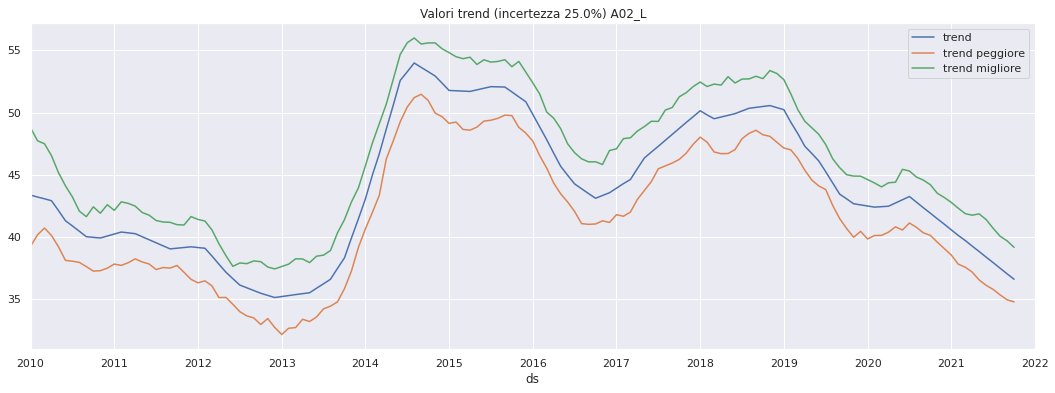

In [741]:
fig = forecast2[['ds','trend','trend_lower','trend_upper']][:-mesi].set_index('ds').plot(figsize=(18,6))
plt.xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]])
plt.title('Valori trend (incertezza '+str(intervallo_incertezza*100)+'%) '+column)
plt.legend(['trend','trend peggiore','trend migliore'])

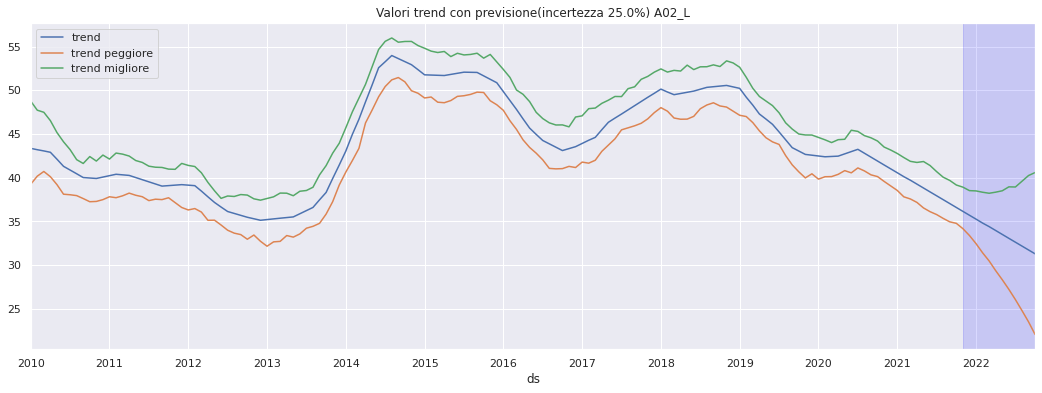

In [742]:
fig = forecast2[['ds','trend','trend_lower','trend_upper']][:].set_index('ds').plot(figsize=(18,6))
plt.xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]])
plt.title('Valori trend con previsione(incertezza '+str(intervallo_incertezza*100)+'%) '+column)
plt.legend(['trend','trend peggiore','trend migliore'])
fig.axes.axvspan(str(forecast2['ds'][-mesi:-mesi+1][forecast2['ds'][-mesi:-mesi+1].index[0]])[:10],str(forecast2['ds'][-1:][forecast2['ds'][-1:].index[0]])[:10],color='Blue',alpha=0.15)

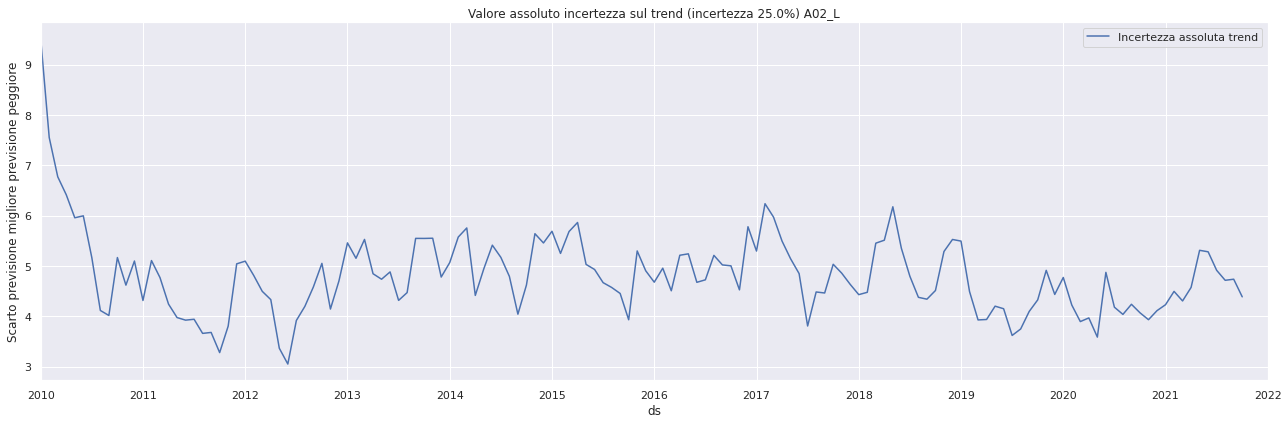

In [743]:
df_output['Incertezza assoluta trend'][:-mesi].plot(figsize=(18,6))
plt.xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]])
plt.ylabel('Scarto previsione migliore previsione peggiore')
plt.title('Valore assoluto incertezza sul trend (incertezza '+str(intervallo_incertezza*100)+'%) '+column)
plt.legend()
plt.tight_layout()


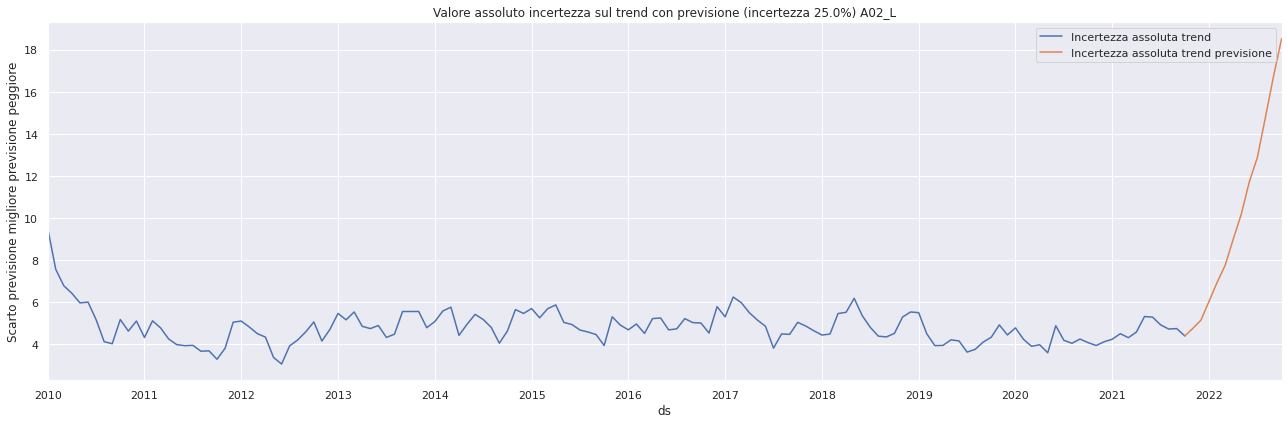

In [744]:
df_output['Incertezza assoluta trend'][:-mesi].plot(figsize=(18,6))
df_output['Incertezza assoluta trend'][-mesi-1:].plot(figsize=(18,6))
plt.xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]])
plt.ylabel('Scarto previsione migliore previsione peggiore')
plt.title('Valore assoluto incertezza sul trend con previsione (incertezza '+str(intervallo_incertezza*100)+'%) '+column)
plt.legend(['Incertezza assoluta trend','Incertezza assoluta trend previsione'])
plt.tight_layout()

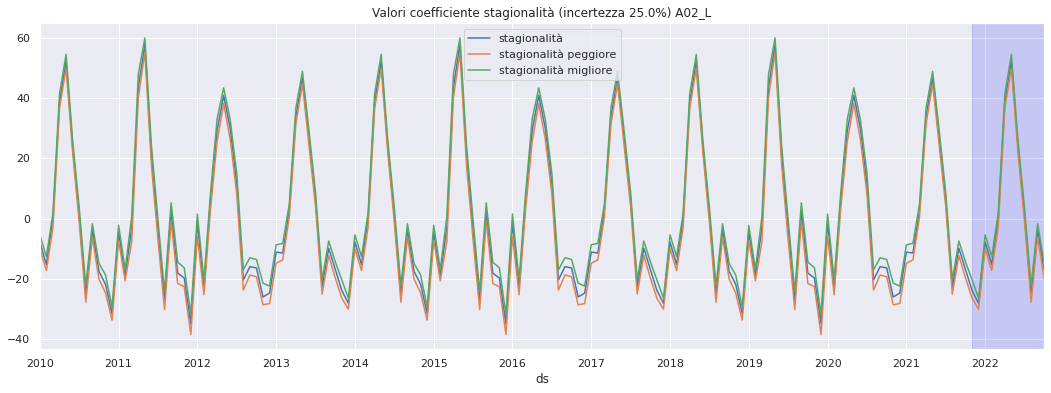

In [745]:
fig = forecast2[['ds','yearly','yearly_lower','yearly_upper']].set_index('ds').plot(figsize=(18,6))
plt.xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]])
plt.title('Valori coefficiente stagionalità (incertezza '+str(intervallo_incertezza*100)+'%) '+column)
plt.legend(['stagionalità','stagionalità peggiore','stagionalità migliore'])
fig.axes.axvspan(str(forecast2['ds'][-mesi:-mesi+1][forecast2['ds'][-mesi:-mesi+1].index[0]])[:10],str(forecast2['ds'][-1:][forecast2['ds'][-1:].index[0]])[:10],color='Blue',alpha=0.15)

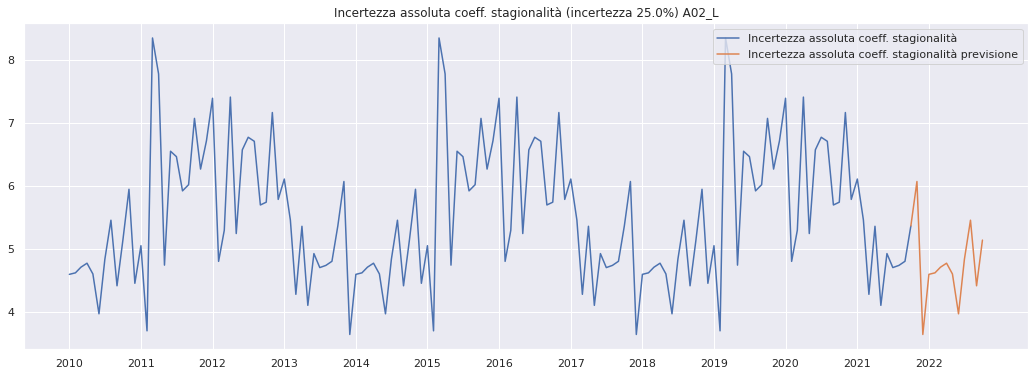

In [746]:
plt.figure(figsize=(18,6))
plt.plot(forecast2[['ds','yearly_upper']][:-mesi].set_index('ds')['yearly_upper']-forecast2[['ds','yearly_lower']].set_index('ds')['yearly_lower'])
plt.plot(forecast2[['ds','yearly_upper']][-mesi-1:].set_index('ds')['yearly_upper']-forecast2[['ds','yearly_lower']].set_index('ds')['yearly_lower'])
plt.xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]])
plt.title('Incertezza assoluta coeff. stagionalità (incertezza '+str(intervallo_incertezza*100)+'%) '+column)
plt.legend(['Incertezza assoluta coeff. stagionalità','Incertezza assoluta coeff. stagionalità previsione'])
plt.show()

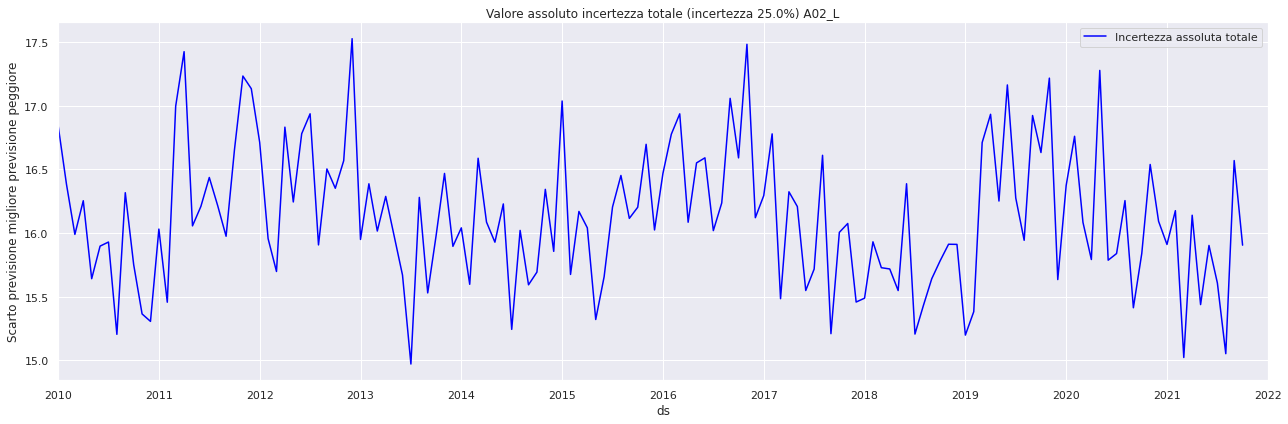

In [749]:
df_output['Incertezza assoluta totale'][:-mesi].plot(figsize=(18,6),color='blue')
plt.xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]])
plt.ylabel('Scarto previsione migliore previsione peggiore')
plt.title('Valore assoluto incertezza totale (incertezza '+str(intervallo_incertezza*100)+'%) '+column)
plt.legend()
plt.tight_layout()

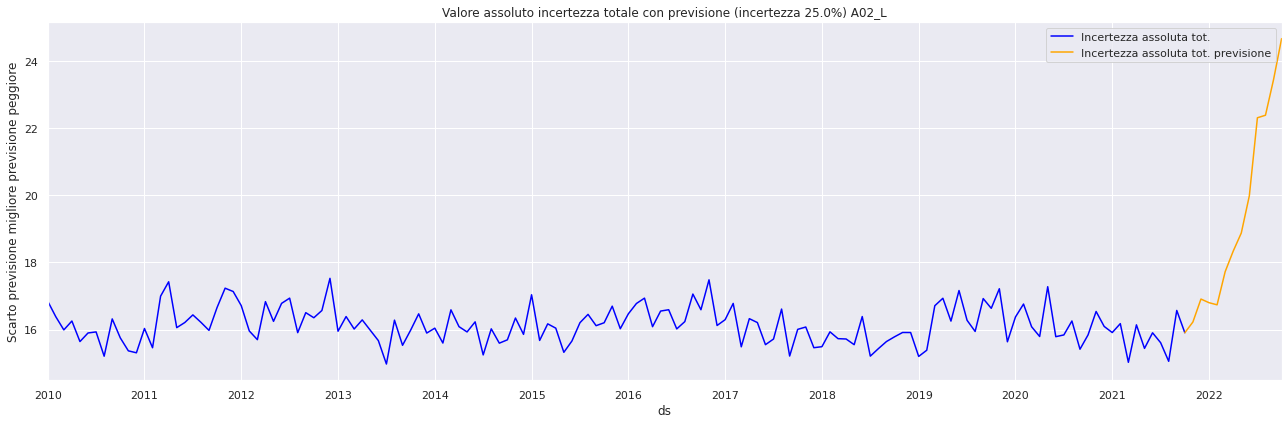

In [751]:
df_output['Incertezza assoluta totale'][:-mesi].plot(figsize=(18,6),color='blue')
df_output['Incertezza assoluta totale'][-mesi-1:].plot(figsize=(18,6),color='orange')
plt.xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]])
plt.ylabel('Scarto previsione migliore previsione peggiore')
plt.title('Valore assoluto incertezza totale con previsione (incertezza '+str(intervallo_incertezza*100)+'%) '+column)
plt.legend(['Incertezza assoluta tot.','Incertezza assoluta tot. previsione'])
plt.tight_layout()